# 2ra parte - Modelos supervisados (Obesity - 2 Estados)

En esta fase posterior, se emplearon modelos como Naive Bayes, árboles de decisión, Random Forest y redes neuronales para discernir cuál de estos modelos supervisados ofrece estimaciones más precisas en la determinación de la obesidad de una persona, considerando tanto sus hábitos alimenticios como su estado físico. Cabe mencionar que se empleó la misma base de datos utilizada anteriormente.

# Preparación de los datos

Se empieza a realizar la importación de las librerias necesarias para el ejercicio

In [114]:
# importar librerias para el proyecto
import pandas as pd
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model, tree
from sklearn.feature_selection import RFE
from sklearn import linear_model, tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import dtreeviz
from sklearn.model_selection import GridSearchCV
import joblib as joblib
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, f1_score, accuracy_score, recall_score
from tabulate import tabulate
#from keras.wrappers.scikit_learn import KerasRegressor
#from scikeras.wrappers import KerasClassifier
from sklearn.metrics import roc_curve, auc


In [115]:
# Cargamos los datos  
datos = pd.read_csv("../Datos/ObesityDataSet_raw_and_data_sinthetic.csv")
datos.head(10)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II
5,Male,29.0,1.62,53.0,no,yes,2.0,3.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Automobile,Normal_Weight
6,Female,23.0,1.50,55.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,0.0,Sometimes,Motorbike,Normal_Weight
7,Male,22.0,1.64,53.0,no,no,2.0,3.0,Sometimes,no,2.0,no,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
8,Male,24.0,1.78,64.0,yes,yes,3.0,3.0,Sometimes,no,2.0,no,1.0,1.0,Frequently,Public_Transportation,Normal_Weight
9,Male,22.0,1.72,68.0,yes,yes,2.0,3.0,Sometimes,no,2.0,no,1.0,1.0,no,Public_Transportation,Normal_Weight


In [116]:
datos.describe()


,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


A continuación, se realizó la separición de las variables categoricas y númericas en conjunto de la separación de la base en testeo y train. Adicionalmente para la variable objetivo "NObeyesdad" se agruparon sus 6 categorias en dos, siendo el estado 1 si el individuo es obeso y 0 que no lo es.

In [117]:
rng = np.random.RandomState(seed=30) # Algo pasa con la semilla pero en X_train la variable CAEC queda sin always, por eso al ajustar el modelo no encuentra la categoría
categorical= ["Gender","family_history_with_overweight", "FAVC","SMOKE", "SCC","CAEC","CALC",'MTRANS']
numerical_columns = ["Age", "FCVC", "NCP", "CH2O", "FAF","TUE"]
X = datos[numerical_columns +categorical]
y = datos["NObeyesdad"]
y = pd.DataFrame(datos['NObeyesdad'].map({'Normal_Weight': 0, 'Insufficient_Weight': 0, 'Overweight_Level_I':0,'Overweight_Level_II':0, 'Obesity_Type_I':1,'Obesity_Type_II':1, 'Obesity_Type_III':1}))
yname = ["NObeyesdad"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=54)

## Preprocessing


Se aplicó la función de ColumnTransformer para llevar a cabo la transformación de los datos. En el caso de las variables categóricas, se empleó la función OneHotEncoder para su conversión a formato numérico. En cuanto a las variables numéricas, se llevó a cabo la escalación utilizando la función StandardScaler.

In [118]:
categorical_encoder = OneHotEncoder(handle_unknown='ignore') 
numerical_pipe = StandardScaler()

preprocessing = ColumnTransformer(
    [
        ("codificacion de categoricas",categorical_encoder, categorical),
        ("Transformación de numéricas", numerical_pipe, numerical_columns)
    ],
    verbose_feature_names_out=False,
)


A continuación, se realiza la estimación de los modelos supervisados y se eligira cual es el mejor para deterinar si los individuos son obesos.

# Logistic Model

Se implementó el modelo logístico mediante las funciones Pipeline y GridSearchCV con el objetivo de generar múltiples modelos logísticos y seleccionar el que obtenga el mejor rendimiento en términos de precisión (accuracy).

In [119]:
logit = LogisticRegression(random_state=30)
modelo_logit = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("Classifier", logit),  
    ]
)

In [120]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=30)
param_grid = {'Classifier__penalty': ['l1', 'l2'],           # Tipo de penalización
              'Classifier__C': [0.001, 0.01, 0.1, 1, 10],    # Parámetro de regularización inversa (más pequeño es más fuerte)
              'Classifier__max_iter': [100, 200, 300],        # Número máximo de iteraciones
              'Classifier__fit_intercept': [True, False],     # Ajustar o no la intercepción
              'Classifier__class_weight': [None, 'balanced'] } # Manejo de clases desbalanceadas}

best_log = GridSearchCV(modelo_logit, param_grid, cv=5, scoring='accuracy')
best_log.fit(X_train, y_train)

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-v

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-v

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_feature_names_out=False)),
                                       ('Classifier',
                                        LogisticRegression(random_state=30))]),
             param_grid={'Classifier__C': [0.001, 0.01, 0.1, 1, 10],
                         'Classifier__class_weight': [None, 'balanced'],
                         'Classifier__fit_intercept': [True, False],
                         'Classifier__max_iter': [100, 200, 300],
                         'Classifier__penalty': ['l1', 'l2']},
             scoring='accuracy')

Dentro de los diferentes modelos lógicticos creados, se eligio el mejor modelo con un accurency de 0.7519 con datos de testeo y de 0.7833 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.8257, bajo las siguientes especificaciones:

- 'Classifier__C': 10: Un valor más alto de C indica una regularización más débil, lo que significa que el modelo puede ajustarse más a los datos de entrenamiento. En este caso es una regularización relativamente débil.

- 'Classifier__class_weight': 'balanced': Las clases menos representadas tendrán un peso mayor para equilibrar el impacto de las clases más frecuentes durante el entrenamiento del modelo.

- 'Classifier__fit_intercept': True: Se permite que el modelo tenga un término de intercepción.

- 'Classifier__max_iter': 200: Representa el número máximo de iteraciones permitidas durante la optimización del modelo.

- 'Classifier__penalty': 'l2': Este parámetro especifica el tipo de regularización que se aplica al modelo. En este caso, 'l2' se refiere a la regularización de norma L2, que penaliza los coeficientes cuadrados grandes en la función de pérdida.


In [121]:
best_log.best_params_

{'Classifier__C': 10,
 'Classifier__class_weight': 'balanced',
 'Classifier__fit_intercept': True,
 'Classifier__max_iter': 200,
 'Classifier__penalty': 'l2'}

En total, se estima que del total de individuos mal clasificados (131), 37 son falsos negativos y 94 son falsos positivos, lo que resulta en una sensibilidad del 0.8477 y una precisión del 0.6867.

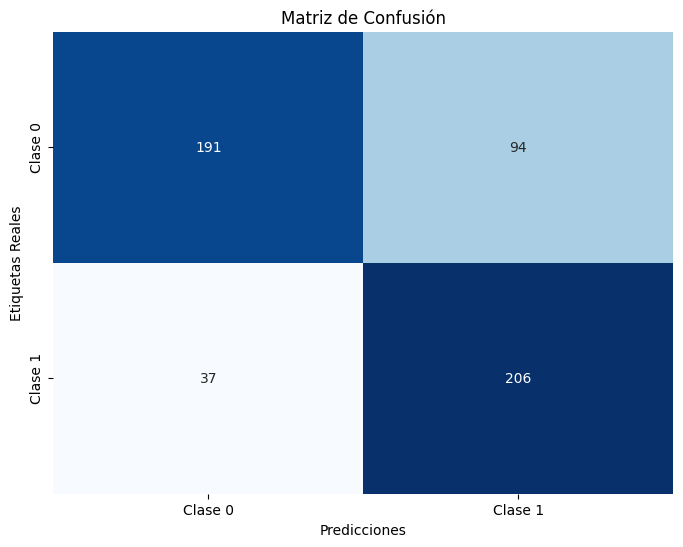

In [122]:
from sklearn.metrics import confusion_matrix

y_test1= pd.DataFrame(y_test)
y_predlog = best_log.predict(X_test)
cm = confusion_matrix(y_test1, y_predlog)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [123]:
print("Rendimiento con datos de entrenamiento",round(best_log.best_score_,4))
print("Rendimiento con datos nuevos", round(best_log.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predlog),4))
print("Precisión", round(precision_score(y_test, y_predlog),4))

Rendimiento con datos de entrenamiento 0.7833
Rendimiento con datos nuevos 0.7519
Sensibilidad 0.8477
Precisión 0.6867


In [124]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predlog))

              precision    recall  f1-score   support

           0       0.84      0.67      0.74       285
           1       0.69      0.85      0.76       243

    accuracy                           0.75       528
   macro avg       0.76      0.76      0.75       528
weighted avg       0.77      0.75      0.75       528



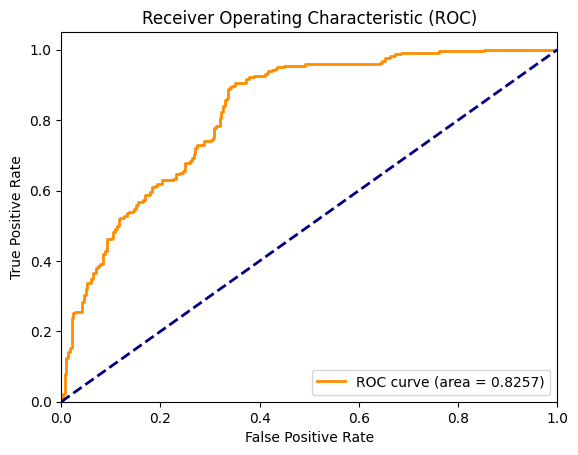

In [125]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_log.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auclog = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auclog)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Arbol de decisión

Se aplicó el modelo con Arbol de decisión utilizando las funciones Pipeline y GridSearchCV, con la finalidad de crear diversos modelos y elegir aquel que logre el mejor desempeño en cuanto a precisión (accuracy).

In [126]:
arbol = DecisionTreeClassifier(random_state=30)
modelo_arbol = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("Classifier", arbol),  
    ]
)

In [127]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=30)
param_grid = {"Classifier__criterion": ['entropy', 'gini','log_loss'],
              "Classifier__max_depth": range(2, 6),
              "Classifier__min_samples_leaf": range(2, 10)}

best_tree = GridSearchCV(modelo_arbol, param_grid, cv=k_fold, scoring='accuracy', n_jobs=-1)
best_tree.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=30, shuffle=True),
             estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_feature_names_out=False)),
                                       ('Classifier',
                                        DecisionTreeClassifier(random_state=30))]),
             n_jobs=-1,
             param_grid={'Classifier__criterion': ['entropy', 'gini',
                                                   'log_loss'],
                         'Classifier__max_depth': range(2, 6),
                         'Classifier__min_samples_leaf': range(2, 10)},
             scoring='accuracy')

Dentro de los diferentes modelos de árbol de decisión creados, se eligio el mejor modelo con un accurency de 0.7386 con datos de testeo y de 0.7896 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.8173, bajo las siguientes especificaciones:

- clasificador__criterion: En este caso, se utiliza el índice de Gini. El índice de Gini mide la impureza de un conjunto de datos, y el algoritmo de árbol de decisión buscará las divisiones que minimicen esta impureza.

- clasificador__max_depth: Este parámetro controla la profundidad máxima del árbol de decisión. Se ha establecido en 5, lo que significa que el árbol se construirá con un máximo de 5 niveles de profundidad desde el nodo raíz hasta las hojas.

- clasificador__min_samples_leaf: Este parámetro establece el número mínimo de muestras requeridas en una hoja del árbol. Lo que significa que una hoja del árbol debe contener al menos 5 muestras.

In [128]:
best_tree.best_params_

{'Classifier__criterion': 'gini',
 'Classifier__max_depth': 5,
 'Classifier__min_samples_leaf': 5}

En total, se estima que del total de individuos mal clasificados (138), 81 son falsos negativos y 57 son falsos positivos, lo que resulta en una sensibilidad del 0.6667 y una precisión del 0.7397

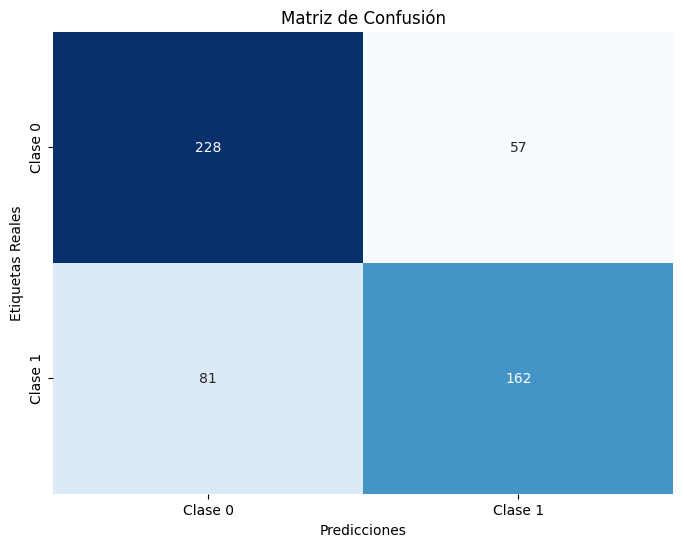

In [129]:
from sklearn.metrics import confusion_matrix

y_test1= pd.DataFrame(y_test)
y_predtree = best_tree.predict(X_test)
cm = confusion_matrix(y_test1, y_predtree)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [130]:
print("Accuracy con datos de entrenamiento",round(best_tree.best_score_,4))
print("Accuracy con datos nuevos", round(best_tree.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predtree),4))
print("Precisión", round(precision_score(y_test, y_predtree),4))

Accuracy con datos de entrenamiento 0.7896
Accuracy con datos nuevos 0.7386
Sensibilidad 0.6667
Precisión 0.7397


In [131]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predtree))

              precision    recall  f1-score   support

           0       0.74      0.80      0.77       285
           1       0.74      0.67      0.70       243

    accuracy                           0.74       528
   macro avg       0.74      0.73      0.73       528
weighted avg       0.74      0.74      0.74       528



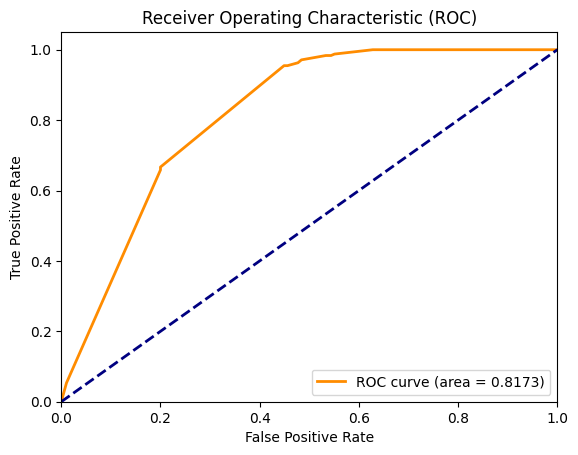

In [132]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_tree.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auctree = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auctree)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Random Forest


Se utilizó la combinación de las funciones Pipeline y GridSearchCV para implementar Random Forest. El propósito fue generar diversos modelos logísticos y identificar aquel que lograra el mejor rendimiento en términos de precisión (accuracy).

In [133]:
# Random Forest
modelo=RandomForestClassifier(random_state=30)
modelo_rf = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("clasificador", modelo),
    ]
)


In [134]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=30)
param_grid = {'clasificador__criterion': ['entropy', 'log_loss', 'gini'],
              'clasificador__max_depth': range(3, 10),
              'clasificador__min_samples_leaf': range(2, 10)}
best_rf = GridSearchCV(modelo_rf, param_grid, scoring='accuracy', n_jobs=-1)
best_rf.fit(X_train, y_train)

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


GridSearchCV(estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_feature_names_out=False)),
                                       ('clasificador',
                                        RandomForestClassifier(random_state=30))]),
             n_jobs=-1,
             param_grid={'clasificador__criterion': ['entropy', 'log_loss',
                                                     'gini'],
                         'clasificador__max_depth': range(3, 10),
                         'clasificador__min_samples_leaf': range(2, 10)},
             scoring='accuracy')

Dentro de los diferentes modelos Random Forest creados, se eligio el mejor modelo con un accurency de 0.8977 con datos de testeo y de 0.8926 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.9579, bajo las siguientes especificaciones:

- clasificador__criterion: Este parámetro indica el criterio utilizado para medir la calidad de una división en el árbol de decisión. En este caso, se ha configurado con 'entropy'. La ganancia de información mide la reducción de la incertidumbre y se utiliza para seleccionar la mejor característica para dividir los nodos del árbol.

- clasificador__max_depth: Este parámetro controla la profundidad máxima del árbol de decisión. En tu configuración, se ha establecido en 9, lo que significa que el árbol se construirá con un máximo de 9 niveles de profundidad desde el nodo raíz hasta las hojas.

- clasificador__min_samples_leaf: Este parámetro establece el número mínimo de muestras requeridas en una hoja del árbol. Lo que significa que una hoja del árbol debe contener al menos 2 muestras.

In [135]:
best_rf.best_params_

{'clasificador__criterion': 'entropy',
 'clasificador__max_depth': 9,
 'clasificador__min_samples_leaf': 2}

En total, se estima que del total de individuos mal clasificados (54), 19 son falsos negativos y 35 son falsos positivos, lo que resulta en una sensibilidad del 0.9218 y una precisión del 0.8649.

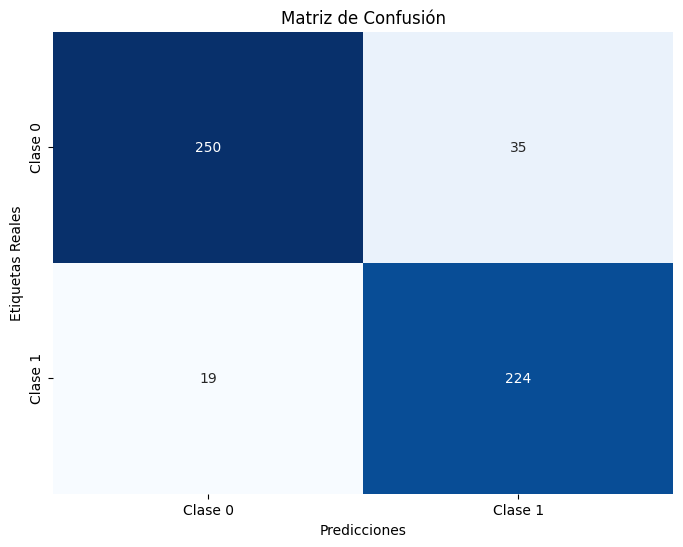

In [136]:
y_test1= pd.DataFrame(y_test)
y_predrf = best_rf.predict(X_test)
cm = confusion_matrix(y_test1, y_predrf)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [137]:
print("Accuracy con datos de entrenamiento",round(best_rf.best_score_,4))
print("Accuracy con datos nuevos", round(best_rf.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predrf),4))
print("Precisión", round(precision_score(y_test, y_predrf),4))

Accuracy con datos de entrenamiento 0.8926
Accuracy con datos nuevos 0.8977
Sensibilidad 0.9218
Precisión 0.8649


In [138]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predrf))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90       285
           1       0.86      0.92      0.89       243

    accuracy                           0.90       528
   macro avg       0.90      0.90      0.90       528
weighted avg       0.90      0.90      0.90       528



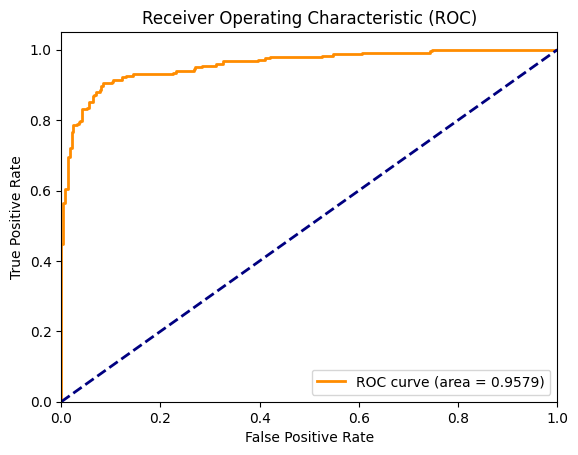

In [139]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_rf.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_aucrf = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_aucrf)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Naive Bayes

Se utilizó la combinación de las funciones Pipeline y GridSearchCV para implementar Naive Bayes. El propósito fue generar diversos modelos logísticos y identificar aquel que lograra el mejor rendimiento en términos de precisión (accuracy).

In [140]:
gnb=GaussianNB()
modelo_GNB = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("Classifier", gnb),  
    ]
)

k_fold = StratifiedKFold(5, shuffle=True, random_state=54)
param_grid = {}
#param_grid ={}
best_GNB = GridSearchCV(modelo_GNB, param_grid, scoring='accuracy', n_jobs=-1)
best_GNB.fit(X_train, y_train)


c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(estimator=Pipeline(steps=[('preprocesamiento',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_feature_names_out=False)),
                                       ('Classifier', GaussianNB())]),
             n_jobs=-1, param_grid={}, scoring='accuracy')

A diferencia de otros modelos, El naive bayes no requiere de hiperparametros para su realización. Sin embargo, mediante la grilla se corrieron varios modelos y al final se escogío el modelo con un accurency de 0.7481 con datos de testeo y de 0.7663 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.8368.

En total, se estima que del total de individuos mal clasificados (133), 17 son falsos negativos y 116 son falsos positivos, lo que resulta en una sensibilidad del 0.9300 y una precisión del 0.6608.

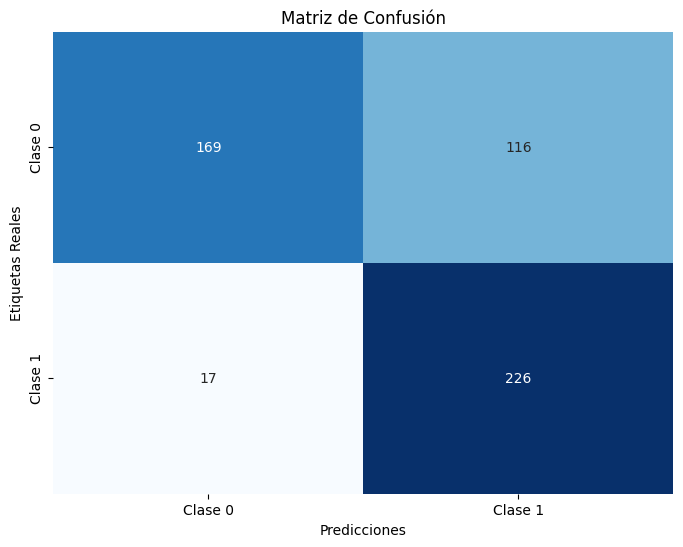

In [141]:
y_test1= pd.DataFrame(y_test)
y_predGNB = best_GNB.predict(X_test)
cm = confusion_matrix(y_test1, y_predGNB)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [142]:
print("Accuracy con datos de entrenamiento",round(best_GNB.best_score_,4))
print("Accuracy con datos nuevos", round(best_GNB.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predGNB),4))
print("Precisión", round(precision_score(y_test, y_predGNB),4))

Accuracy con datos de entrenamiento 0.7663
Accuracy con datos nuevos 0.7481
Sensibilidad 0.93
Precisión 0.6608


In [143]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predGNB))

              precision    recall  f1-score   support

           0       0.91      0.59      0.72       285
           1       0.66      0.93      0.77       243

    accuracy                           0.75       528
   macro avg       0.78      0.76      0.75       528
weighted avg       0.79      0.75      0.74       528



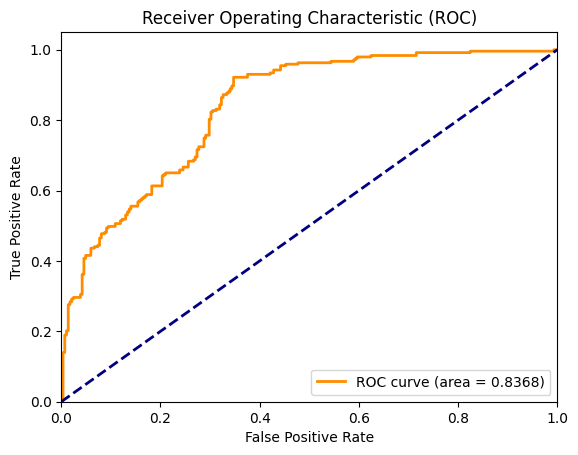

In [144]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_GNB.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_aucGNB = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_aucGNB)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Redes Neuronales

Se utilizó la combinación de las funciones Pipeline y GridSearchCV para implementar Redes Neuronales. El propósito fue generar diversos modelos de Redes Neuronales y identificar aquel que lograra el mejor rendimiento en términos de precisión (accuracy).

In [145]:
red = Sequential()
red.add(Dense(1, input_shape=(28,) ,activation='softmax'))
red.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


modelo_red = Pipeline(
    [
    ("preprocesamiento", preprocessing),
    ("Classifier", red),
    ]
)

modelo_red.fit(X_train, y_train)


c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\keras\src\losses\losses.py:22: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.4587 - loss: 0.0000e+00 


Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('codificacion de categoricas',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'family_history_with_overweight',
                                                   'FAVC', 'SMOKE', 'SCC',
                                                   'CAEC', 'CALC', 'MTRANS']),
                                                 ('Transformación de numéricas',
                                                  StandardScaler(),
                                                  ['Age', 'FCVC', 'NCP', 'CH2O',
                                                   'FAF', 'TUE'])],
                                   verbose_feature_names_out=False)),
                ('Classifier', <Sequential name=sequential_2, built=True>)])

In [146]:
red_neuronal = MLPClassifier(random_state=30)
rn_mlp = Pipeline(
    [
    ("preprocessing",preprocessing),
    ("Classifier",red_neuronal)    
    ]
)

In [147]:
k_fold = StratifiedKFold(5, shuffle=True, random_state=30)
param_grid ={ "Classifier__hidden_layer_sizes":[(10,), (20,), (30,)],
             "Classifier__activation":['identity','logistic','tanh','relu'],
             "Classifier__solver":['lbfgs','sgd','adam'],
             "Classifier__alpha":[0.0001, 0.001, 0.01, 0.1],
             "Classifier__learning_rate":['constant','invscaling','adaptative']}


best_neuralnetwork = GridSearchCV(rn_mlp, param_grid, scoring='accuracy', n_jobs=-1)
best_neuralnetwork.fit(X_train, y_train)

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
720 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
185 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\LauraCuestas\anaconda3\envs\t

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('codificacion '
                                                                         'de '
                                                                         'categoricas',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'CAEC',
                                                                          'CALC',
                                                                          'MTRANS']),
                                                                        ('Transformación '
                                                                         'de '
                                                                         'numéricas',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])],
                                                          verbose_f...
                                       ('Classifier',
                                        MLPClassifier(random_state=30))]),
             n_jobs=-1,
             param_grid={'Classifier__activation': ['identity', 'logistic',
                                                    'tanh', 'relu'],
                         'Classifier__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'Classifier__hidden_layer_sizes': [(10,), (20,),
                                                            (30,)],
                         'Classifier__learning_rate': ['constant', 'invscaling',
                                                       'adaptative'],
                         'Classifier__solver': ['lbfgs', 'sgd', 'adam']},
             scoring='accuracy')

Apartir de la realización de diferentes modelos de redes neuronales, se eligio el mejor modelo con un accurency de 0.8977 con datos de testeo y de 0.9160 con datos de entrenamiento. Además, presentó un área bajo la curva (AUC) de 0.9463, bajo las siguientes especificaciones:

- Classifier__activation: 'logistic'
En este caso, se ha seleccionado la función logística (también conocida como función sigmoide). La función logística transforma la entrada en un rango entre 0 y 1.

- Classifier__alpha: 0.1
La regularización ayuda a prevenir el sobreajuste al penalizar pesos grandes. Un valor de alpha más alto implica una regularización más fuerte y el implementado en este modelo es relativamente alto.

- Classifier__hidden_layer_sizes: (30,)
Indica la arquitectura de la red neuronal, es decir, el número de neuronas en cada capa oculta. En este caso, hay una única capa oculta con 30 neuronas.

- Classifier__learning_rate: 'invscaling'
En este caso, se utiliza la tasa de aprendizaje 'invscaling', que reduce la tasa de aprendizaje a medida que avanza el entrenamiento.

- Classifier__solver: 'lbfgs'
Se ha seleccionado 'lbfgs', que es un algoritmo de optimización de segundo orden bien adaptado para problemas de optimización convexa.

In [148]:
best_neuralnetwork.best_params_

{'Classifier__activation': 'logistic',
 'Classifier__alpha': 0.1,
 'Classifier__hidden_layer_sizes': (30,),
 'Classifier__learning_rate': 'constant',
 'Classifier__solver': 'lbfgs'}


En total, se estima que del total de individuos mal clasificados (59), 20 son falsos negativos y 39 son falsos positivos, lo que resulta en una sensibilidad del 0.9177 y una precisión del 0.8511.

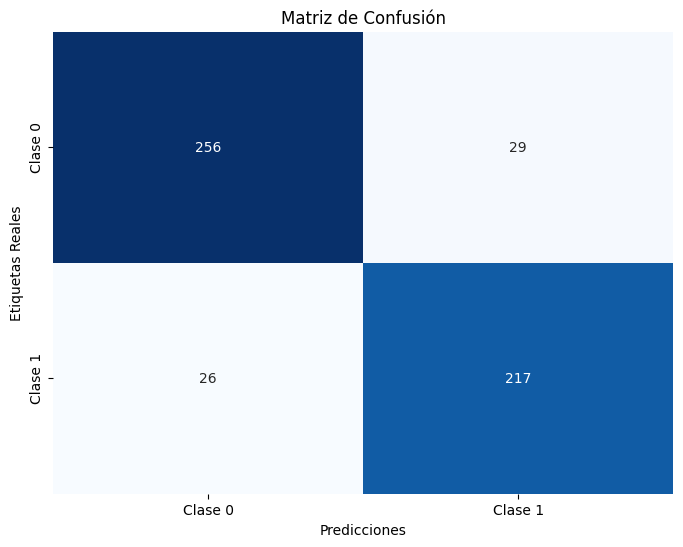

In [149]:
y_test1= pd.DataFrame(y_test)
y_predRED = best_neuralnetwork.predict(X_test)
cm = confusion_matrix(y_test1, y_predRED)
# Configuración de la matriz de confusión usando seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])],
            yticklabels=['Clase {}'.format(i) for i in range(cm.shape[0])])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

plt.show()

In [150]:
print("Accuracy con datos de entrenamiento",round(best_neuralnetwork.best_score_,4))
print("Accuracy con datos nuevos", round(best_neuralnetwork.score(X_test,y_test),4))
print("Sensibilidad", round(recall_score(y_test, y_predRED),4))
print("Precisión", round(precision_score(y_test, y_predRED),4))

Accuracy con datos de entrenamiento 0.9033
Accuracy con datos nuevos 0.8958
Sensibilidad 0.893
Precisión 0.8821


In [151]:
from sklearn.metrics import classification_report
print(classification_report(y_test1, y_predRED))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       285
           1       0.88      0.89      0.89       243

    accuracy                           0.90       528
   macro avg       0.89      0.90      0.90       528
weighted avg       0.90      0.90      0.90       528



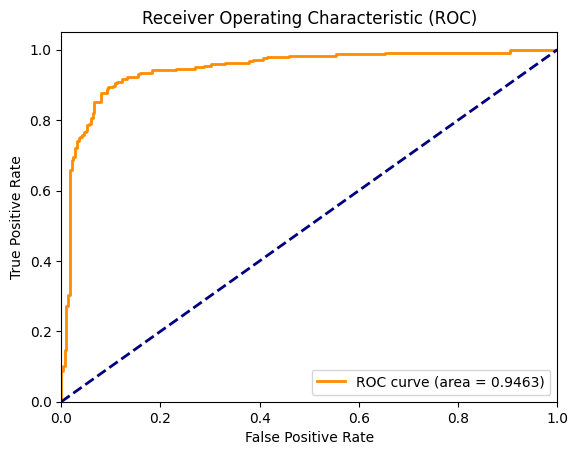

In [152]:
# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scores = best_neuralnetwork.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_aucRED = auc(fpr, tpr)

# Plotear la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_aucRED)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

Al comparar todos los modelos mencionados anteriormente, se evidencia que la Random Forest muestra una precisión superior en la predicción de personas con obesidad (Precisión: 0.8821). Además, exhibe una exactitud global mayor que la de los demás modelos (Accuracy: 0.9579). Es destacable que la Random Forest también presenta uno de los AUC más elevados en comparación con los otros modelos. Esto sugiere una capacidad de clasificación y discriminación más sólida en relación con los diferentes estados de la variable obesidad.

In [153]:
data = {'Modelo':['Logistico', 'Arbol de decisión', 'Random Forest', 'Naive Bayes', 'Red Neuronal'],
        'Precisión':[round(precision_score(y_test, y_predlog),ndigits=4), round(precision_score(y_test, y_predtree),ndigits=4), round(precision_score(y_test, y_predrf),ndigits=4), round(precision_score(y_test, y_predGNB),ndigits=4), round(precision_score(y_test, y_predRED),ndigits=4)],
        'Sensibilidad':[round(recall_score(y_test, y_predlog),ndigits=4), round(recall_score(y_test, y_predtree),ndigits=4), round(recall_score(y_test, y_predrf),ndigits=4), round(recall_score(y_test, y_predGNB),ndigits=4), round(recall_score(y_test, y_predRED),ndigits=4)],
        'F1':[round(f1_score(y_test, y_predlog),ndigits=4), round(f1_score(y_test, y_predtree),ndigits=4), round(f1_score(y_test, y_predrf),ndigits=4), round(f1_score(y_test, y_predGNB),ndigits=4), round(f1_score(y_test, y_predRED),ndigits=4)],
        'AUC':[round(roc_auclog,ndigits=4), round(roc_auctree,ndigits=4), round(roc_aucrf,ndigits=4), round(roc_aucGNB,ndigits=4), round(roc_aucRED,ndigits=4)],
        'Accuracy':[round(best_log.score(X_test,y_test),4), round(best_tree.score(X_test,y_test),4), round(best_rf.score(X_test,y_test),4), round(best_GNB.score(X_test,y_test),4), round(best_neuralnetwork.score(X_test,y_test),4)]}
Modelo=['Logistico', 'Arbol de decisión', 'Random Forest', 'Naive Bayes', 'Red Neuronal']
data = pd.DataFrame(data, index=None)


print(tabulate(data.sort_values(by='Accuracy', ascending=False), headers='keys', tablefmt='pretty', showindex=False))

+-------------------+-----------+--------------+--------+--------+----------+
|      Modelo       | Precisión | Sensibilidad |   F1   |  AUC   | Accuracy |
+-------------------+-----------+--------------+--------+--------+----------+
|   Random Forest   |  0.8649   |    0.9218    | 0.8924 | 0.9579 |  0.8977  |
|   Red Neuronal    |  0.8821   |    0.893     | 0.8875 | 0.9463 |  0.8958  |
|     Logistico     |  0.6867   |    0.8477    | 0.7587 | 0.8257 |  0.7519  |
|    Naive Bayes    |  0.6608   |     0.93     | 0.7726 | 0.8368 |  0.7481  |
| Arbol de decisión |  0.7397   |    0.6667    | 0.7013 | 0.8173 |  0.7386  |
+-------------------+-----------+--------------+--------+--------+----------+


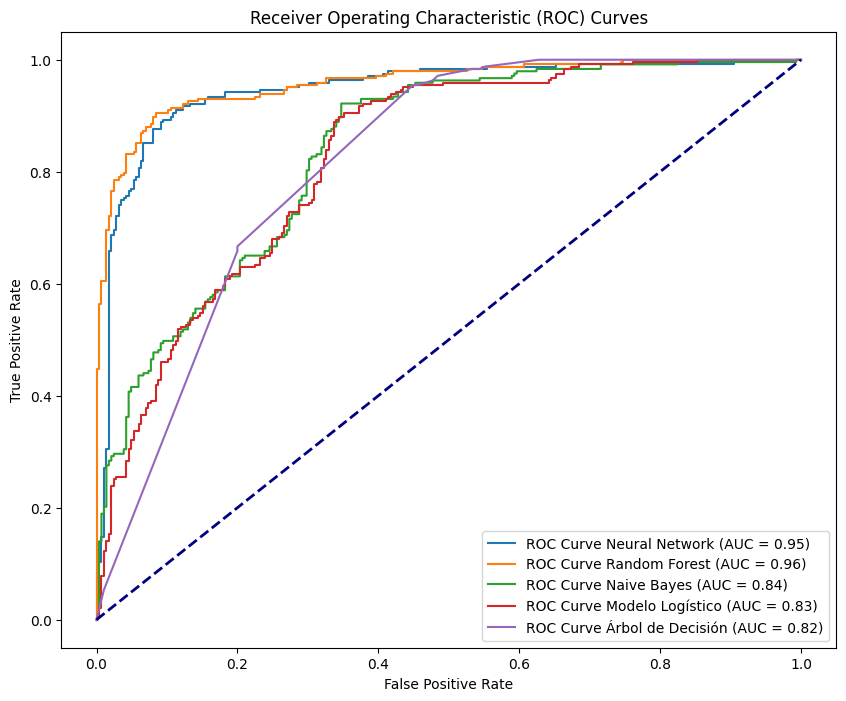

In [154]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Obtener las predicciones de probabilidad en el conjunto de prueba
y_scoresRed = best_neuralnetwork.predict_proba(X_test)[:, 1]
y_scoresRF = best_rf.predict_proba(X_test)[:, 1]
y_scoresGNB = best_GNB.predict_proba(X_test)[:, 1]
y_scoresLog = best_log.predict_proba(X_test)[:, 1]
y_scoresTree = best_tree.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

# Supongamos que tienes tres conjuntos de datos de prueba y predicciones
# Guarda las tasas de verdaderos positivos (TPR) y tasas de falsos positivos (FPR) para cada conjunto
fpr1, tpr1, _ = roc_curve(y_test, y_scoresRed)
fpr2, tpr2, _ = roc_curve(y_test, y_scoresRF)
fpr3, tpr3, _ = roc_curve(y_test, y_scoresGNB)
fpr4, tpr4, _ = roc_curve(y_test, y_scoresLog)
fpr5, tpr5, _ = roc_curve(y_test, y_scoresTree)

# Calcula el área bajo la curva (AUC) para cada conjunto de datos
roc_auc1 = auc(fpr1, tpr1)
roc_auc2 = auc(fpr2, tpr2)
roc_auc3 = auc(fpr3, tpr3)
roc_auc4 = auc(fpr4, tpr4)
roc_auc5 = auc(fpr5, tpr5)

# Crea una figura y subgráficos
fig, ax = plt.subplots(figsize=(10, 8))

# Traza las curvas ROC para cada conjunto de datos en subgráficos diferentes
ax.plot(fpr1, tpr1, label=f'ROC Curve Neural Network (AUC = {roc_auc1:.2f})')
ax.plot(fpr2, tpr2, label=f'ROC Curve Random Forest (AUC = {roc_auc2:.2f})')
ax.plot(fpr3, tpr3, label=f'ROC Curve Naive Bayes (AUC = {roc_auc3:.2f})')
ax.plot(fpr4, tpr4, label=f'ROC Curve Modelo Logístico (AUC = {roc_auc4:.2f})')
ax.plot(fpr5, tpr5, label=f'ROC Curve Árbol de Decisión (AUC = {roc_auc5:.2f})')

# Agrega la línea diagonal para la clasificación aleatoria en todos los subgráficos
ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Etiqueta los ejes y agrega una leyenda
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curves')
ax.legend(loc='lower right')

# Muestra la gráfica
plt.show()

# Interpretación del Mejor modelo: Random Forest

En el modelo random forest, como se mencionó anteriormente se seleccionó el mejor modelo con los siguientes hiperparametros:

- clasificador__criterion: 'entropy'
- clasificador__max_depth: 9 
- clasificador__min_samples_leaf: 2

In [155]:
def custom_transformer(X):
    # Definir las columnas categóricas y numéricas según tu conjunto de datos
    categorical= ["Gender","family_history_with_overweight", "FAVC","SMOKE", "SCC","CAEC","CALC",'MTRANS']
    numerical_columns = ["Age", "FCVC", "NCP", "CH2O", "FAF","TUE"]

    # Crear un ColumnTransformer con las transformaciones deseadas
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_columns),  # Estandarizar variables numéricas
            ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)  # Codificar variables categóricas
        ],
    )

    # Devolver el conjunto de datos transformado
    return preprocessor.fit_transform(X)

In [156]:
X_train2 = custom_transformer(X_train)
X_train2 = pd.DataFrame(X_train2)

In [157]:
RandomForest = RandomForestClassifier(criterion='entropy',
        max_depth=9,
        min_samples_leaf= 2,
        random_state=30)

RandomForest.fit(X_train2, y_train)
print(best_rf.best_score_, best_rf.score(X_test,y_test))

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.8926266821067763 0.8977272727272727


Para su análisis se tendrá en cuenta en primera instancia la importancia de características para la estimación del modelo. Como resultado, se obtuvo que las variables de genero (Gender: Female y Male), ¿Controlas las calorías que comes diariamente? (SCC:sí y no) y ¿su familia tiene antecedentes de sobrepeso? (family_history_with_overweight: no) son las más significativas para clasificar a las personas con obesidad, como se muestra en la gráfica de “Importancia de características (MDI)” 

In [158]:
primer_paso=modelo_rf['preprocesamiento']
primer_paso.fit(X_train, y_train)
primer_paso.get_feature_names_out()
primer_paso.transform(X_train)
import pandas as pd
DF=pd.DataFrame(primer_paso.transform(X_train), columns=primer_paso.get_feature_names_out())

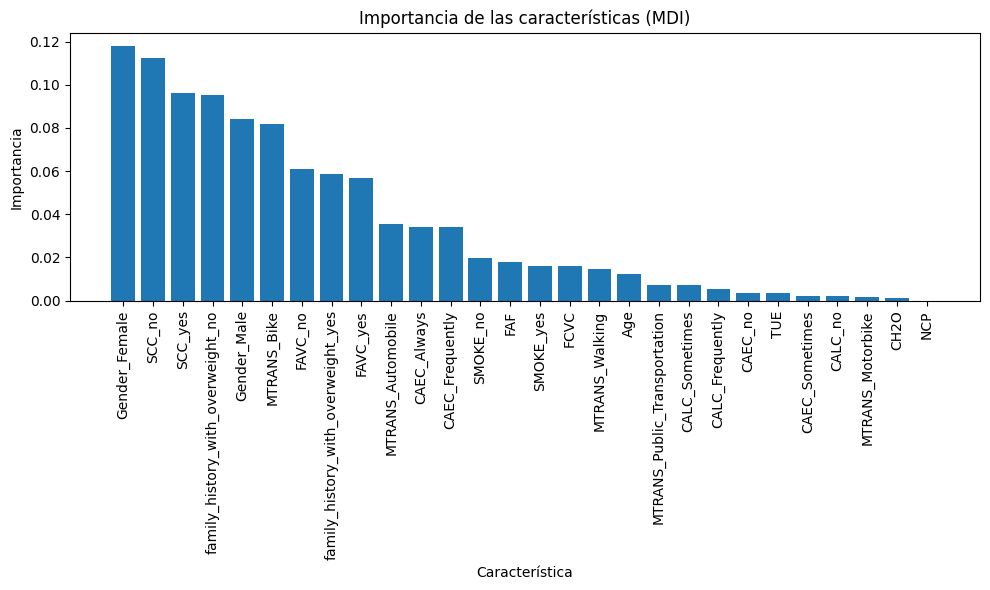

In [159]:
feature_importance = RandomForest.feature_importances_
feature_names = DF.columns
sorted_indices = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(10, 6))

# Graficar la importancia de las características
plt.bar(range(len(feature_importance)), feature_importance[sorted_indices], align='center')
plt.xticks(range(len(feature_importance)), [feature_names[i] for i in sorted_indices], rotation=90)
plt.xlabel('Característica')
plt.ylabel('Importancia')
plt.title('Importancia de las características (MDI)')
plt.tight_layout()

# Mostrar la gráfica
plt.show()


Después de analizar el error y los puntajes del modelo, se buscó determinar el número ideal de árboles para maximizar la precisión del modelo de Random Forest en la clasificación de los niveles de obesidad en personas.

- Se ha generado la gráfica "Evolución del puntaje de entrenamiento y Out-of-Bag", que contrasta el rendimiento logrado utilizando los datos empleados por los árboles de Random Forest con la información no utilizada en la construcción del modelo. Se ha observado que tanto en los datos de entrenamiento como en los de Out-of-Bag, el número óptimo de árboles oscilaba alrededor de 250. No obstante, se ha notado que a partir del vigésimo árbol, el puntaje se estabilizó, indicando que 20 árboles podrían ser suficientes para obtener resultados satisfactorios.

- Para complementar, se ha generado la gráfica "Evolución del error de validación cruzada vs error del modelo", la cual compara la evolución del error obtenido utilizando los datos empleados por los árboles de Random Forest con el error resultante al evaluar el modelo utilizando k-fold cross-validation. En este procedimiento, los datos se dividen en k partes (folds), y el modelo se entrena k veces, utilizando cada fold como conjunto de prueba una vez y los k-1 folds restantes como conjunto de entrenamiento. Esto brinda una estimación más fiable del rendimiento del modelo en comparación con el simple error de entrenamiento. Se ha observado que tanto en los datos de entrenamiento como en los de k-fold cross-validation, el número óptimo de árboles rondaba los 130. No obstante, se ha notado que a partir del vigésimo árbol, el error se estabilizó, sugiriendo que 20 árboles podrían ser suficientes para obtener resultados satisfactorios.

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

Valor óptimo de n_estimators: 231


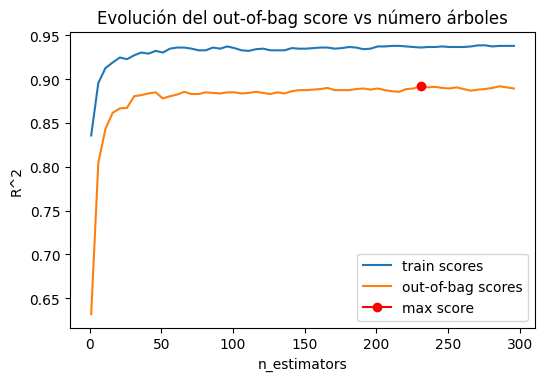

In [160]:
from sklearn.ensemble import RandomForestRegressor
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 300, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestClassifier(
                n_estimators = n_estimators,
                oob_score    = True,
                criterion='entropy',
                max_depth=9,
                min_samples_leaf= 2,
                random_state=30)
    modelo.fit(DF, y_train)
    train_scores.append(modelo.score(DF, y_train))
    oob_scores.append(modelo.oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag score vs número árboles")
plt.legend()
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")

c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\LauraCuestas\anaconda3\envs\tensor_310\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change 

Valor óptimo de n_estimators: 131


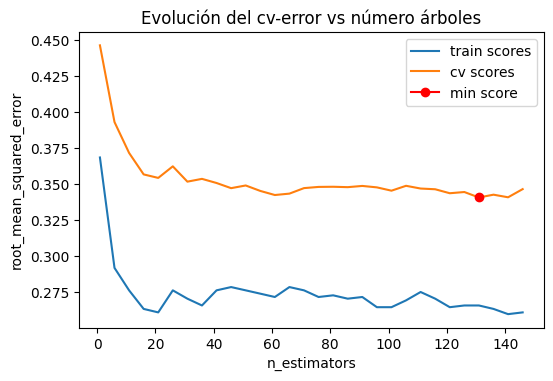

In [161]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:
    
    modelo = RandomForestClassifier(
                n_estimators = n_estimators,
                oob_score    = True,
                criterion='entropy',
                max_depth=9,
                min_samples_leaf= 2,
                random_state=30)
    
    # Error de train
    modelo.fit(X_train2, y_train)
    predicciones = modelo.predict(X = X_train2)
    rmse = mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
            squared = False
           )
    train_scores.append(rmse)
    
    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train2,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend()
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")